# Advanced Segmentation: The Watershed Transform

*This tutorial was prepared by Griffin Chure and was generated from a Jupyter notebook. You can download the notebook [here](http://bebi103.caltech.edu/2015/tutorials/r8_watershed_transform.html).*

In [220]:
import warnings

# Our numerical workhorse
import numpy as np

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation
import skimage.measure
import skimage.feature
import scipy.ndimage

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Import file management tools. 
import glob 
import os 
import shutil 

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Over the past three weeks, we have learned an impressive amount image processing. However, we have only scraped the surface of an enormous field of research.


As has been mentioned repeatedly in class, our eyes are **not** quantitative instruments. When we are interested in extracting quantiative information from images, we are better off turning to our silicon-based overlords to crunch the numbers. However, our eyes are incredibly good at separating objects and identifying and are, in most cases, superior to current computer based techniques. The field is called "computer *vision*" for a reason!

* Main groups of image processing techniques: 1. Threshold based methods 2. Edge based methods 3. Group based methods (k-means) 4. Compression based methods. 

* Give resources to look at other means of image processing/computer vision.

* Today we are going to focus on a more advanced yet very commonly used algorithm for image segmentation called the watershed transform.

## What the hell is a watershed?

### The data set: measuring bacterial growth at single-cell resolution

Before we get into the nitty gritty of watershed segmentation, let's look at a biological problem. In homework 8, you were tasked with determining if a single bacterial cell grows exponentially or linearly. Today, we'll watch a single *E. coli* elongate and divide on a hard substrate over the course of 6 hours until a microcolony is formed. By counting the number of cells at each time point, we will be able to determine if population growth is exponential (spoiler -- it is).

Some important points to note.
    1. The time between each image is 15 minutes. 
    2. The cells are grown on an agarose pad made of minimal media.
    3. The images come in both phase and fluorescence. These cells are constitutively expressing YFP from a chromosomal integration.

Let's load up the first and last frame of the experiment to see what we are dealing with. 

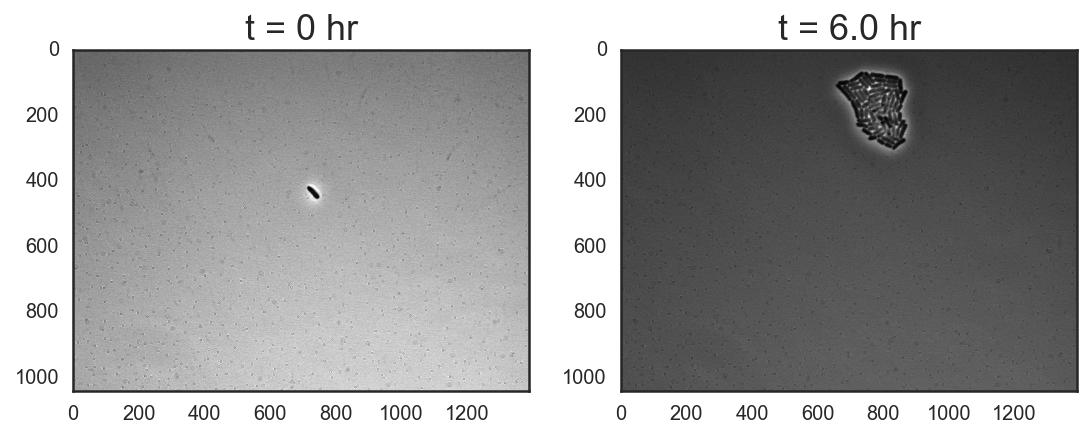

In [265]:
# Define the data directory.
data_dir = '../data/colony_growth/'
phase_im = '*phase.tif'
fitc_im  = '*FITC.tif'

# Glob 'em up. 
phase_glob = glob.glob(data_dir + phase_im)
fitc_glob = glob.glob(data_dir + fitc_im)

#Load up the phase images as an ImageCollection
ic = skimage.io.ImageCollection(phase_glob, conserve_memory=False)
time = np.linspace(0, 24 * 15 / 60)
#Look at the first and last image. 
with sns.axes_style('white'):
    plt.close('all')
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(ic[0], cmap=plt.cm.gray)
    ax[1].imshow(ic[-1], cmap=plt.cm.gray)
    
    #Set the titles for each. 
    ax[0].set_title('t = 0 hr')
    ax[1].set_title('t = %s hr' %time[-1])

We can see that the found the meaning of life and successfully reproducced! Let's take a closer look at the colony in the last image. 


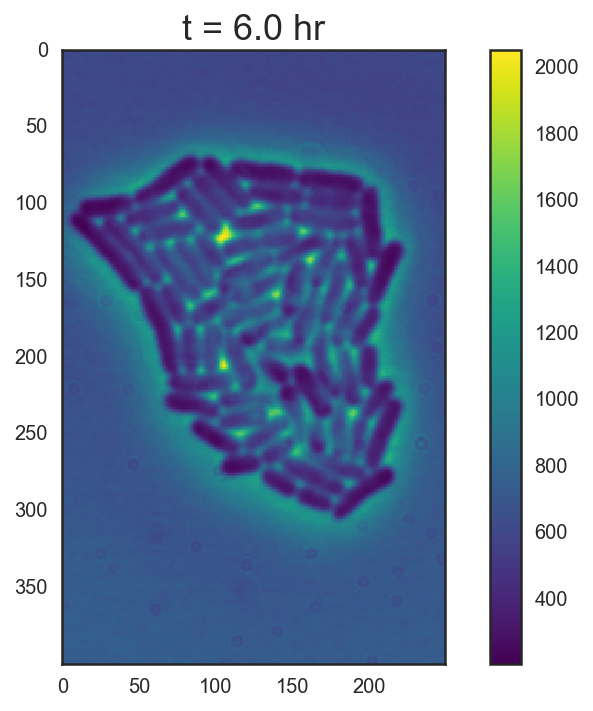

In [266]:
with sns.axes_style('white'):
    plt.imshow(ic[-1][0:400, 650:900], cmap=plt.cm.viridis)
    plt.title('t = %s hr' %time[-1])
    plt.colorbar()

Now that is an image processing nightmare! As the microcolony grows, cells in the middle of the colony begin to get pushed and stack up on top of each other, generating a three-dimensional colony. This makes matters quite difficult for thresholding. Let's try just thresholding by eye and see how we do.

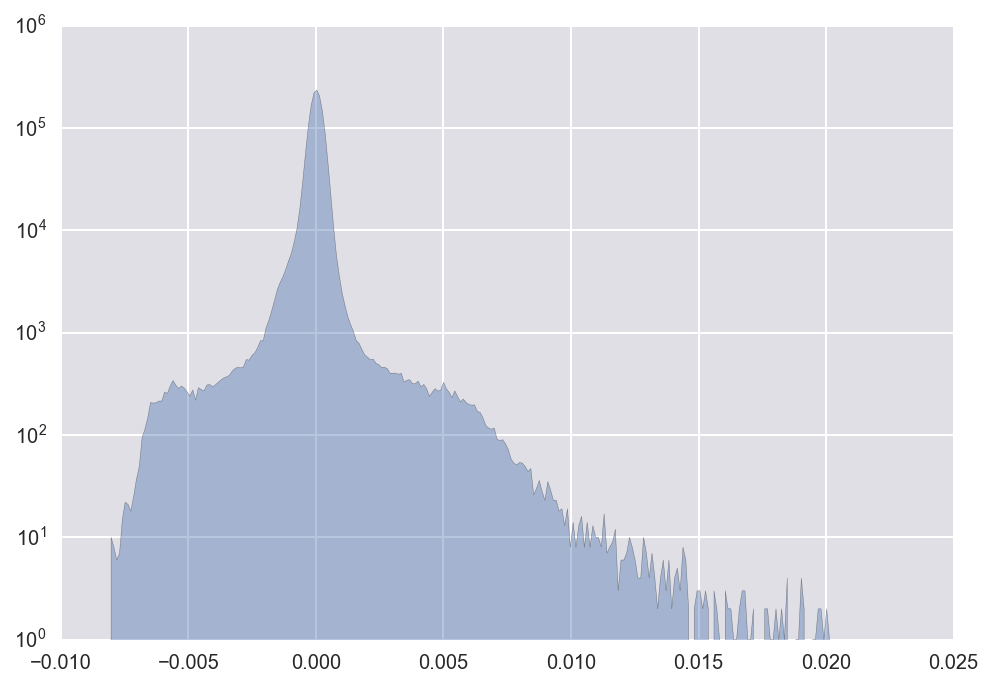

In [288]:
#Blur and do a subtraction. 
im_blur = skimage.filters.gaussian_filter(ic[-1], 20)
#convert the image to a float. 
im = skimage.img_as_float(ic[-1])
im = im - im_blur
# Take a look at the image histogram to draw a threshold. 
hist, bins = skimage.exposure.histogram(im)
plt.fill_between(bins, hist, lw=0.25, alpha=0.4)
plt.yscale('log')

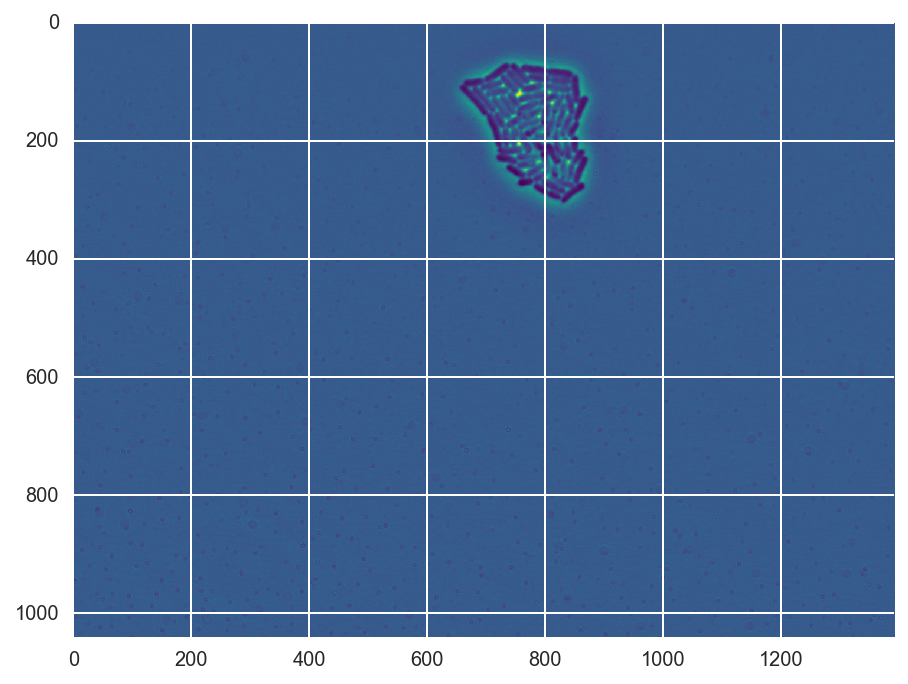

In [289]:
plt.imshow(im, cmap=plt.cm.viridis)

By eye, i think I can say that drawing a threshold around 500 is okay. Let's see how it works. 

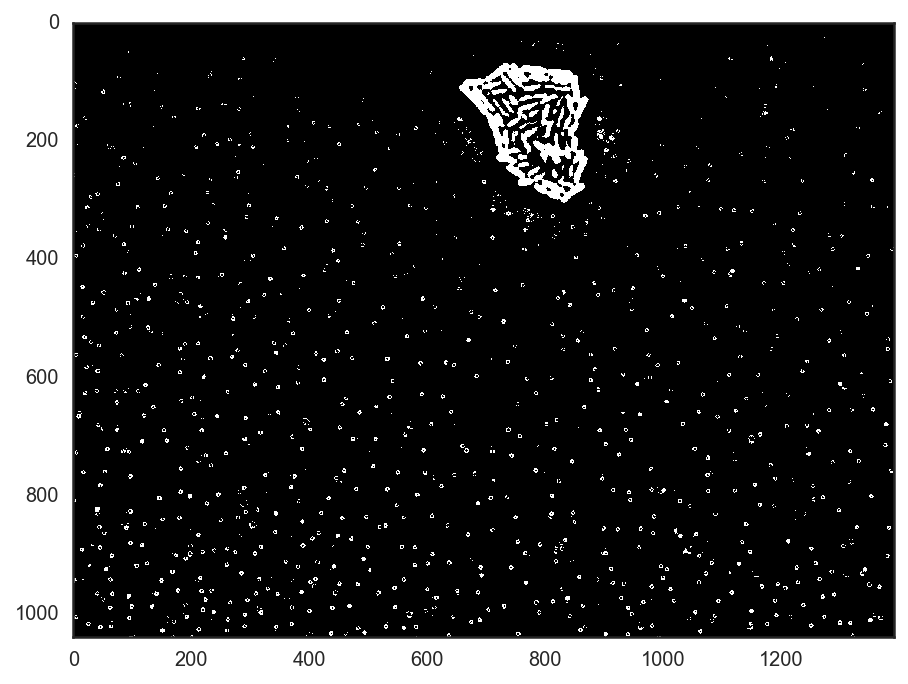

In [290]:
# Define the threshold. 
thresh = -0.001
im_thresh = im < thresh

with sns.axes_style('white'):
    plt.imshow(im_thresh, cmap=plt.cm.gray)
    

Yikes! We lost nearly the entire center of the colony! Let's see if watershed can help us at all.

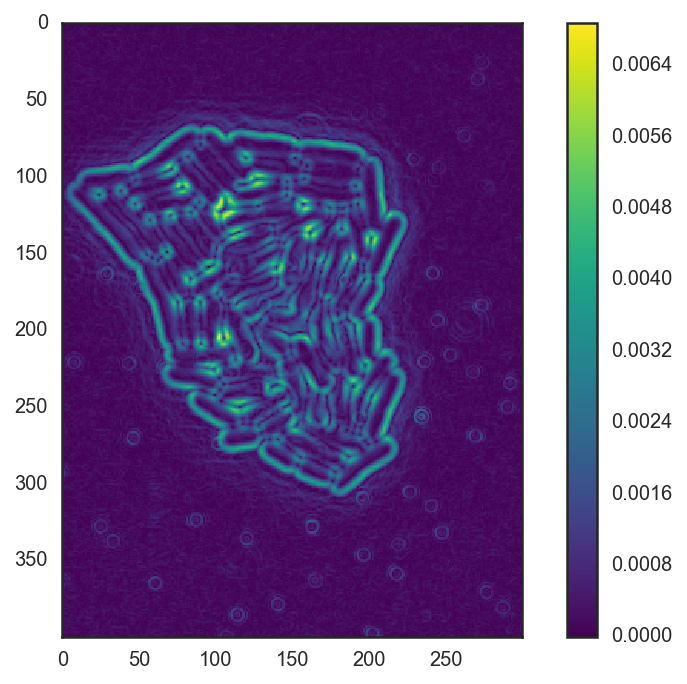

In [292]:
#Do a gaussian subtraction. 
im_blur = skimage.filters.gaussian_filter(im, 50)

# Compute the gradient of the image using our favorite Sobel filter. 
im_sobel = skimage.filters.sobel(im)
with sns.axes_style('white'):
    plt.imshow(im_sobel[0:400, 650:950], cmap=plt.cm.viridis)
    plt.colorbar()

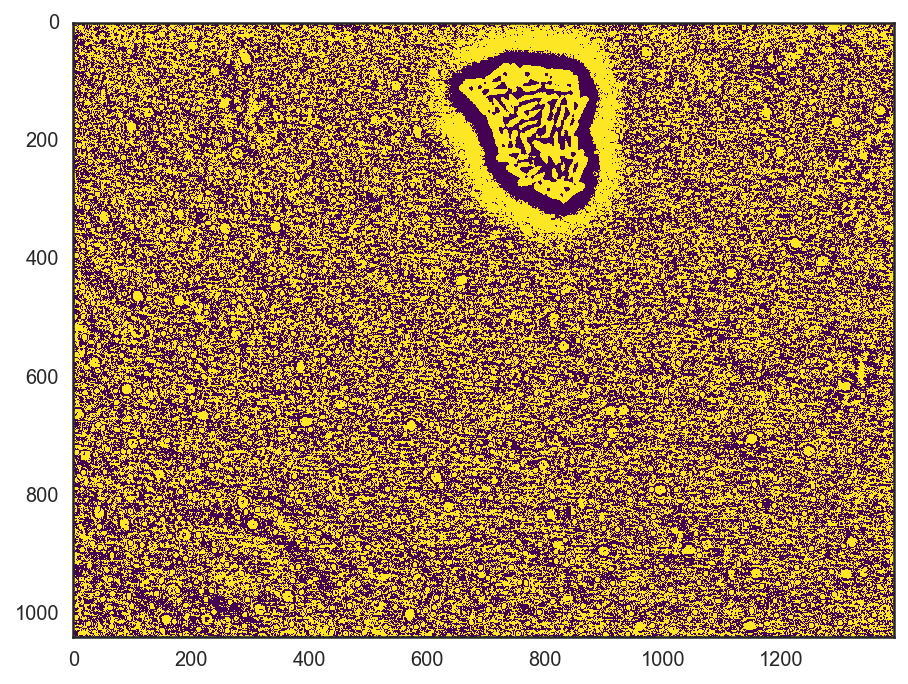

In [310]:
# Define the markers for the watershed. 
markers = np.zeros_like(im)
markers[im > -0.009] = 1
markers[im <0.00] = 2
with sns.axes_style('white'):
    plt.imshow(markers, plt.cm.viridis)
    
    

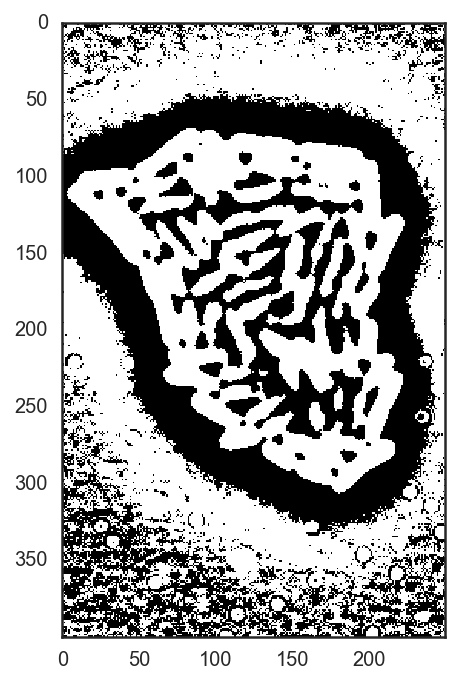

In [311]:
# Now apply the watershed. 
im_seg = skimage.morphology.watershed(im_sobel, markers)
with sns.axes_style('white'):
    plt.imshow(im_seg[0:400, 650:900], cmap=plt.cm.gray)

In [43]:
im_seg = skimage.filters.sobel?

In [ ]:
im_seg = skimage.filters.sobel

In [ ]:
im_seg = skimage.morphology.watershed

### Watershed by distance

In [168]:
def log_segmentation(im, selem, thresh=0.001, radius=2.0):
    """
    This function computes the Laplacian of a gaussian filtered image and
    detects object edges as regions which cross zero in the derivative. The
    arguments are as follows:

    im = fluorescence image to be filtered and segmented.
    radius = radius for gaussian filter.
    selem = structural element to be applied for laplacian calculation.
    thresh = threshold to define gradients
    """
     
    #Ensure that the provided image is a float. 
    im_float = (im - im.min()) / (im.max() - im.min())
    
    #Subtract background to fix illumination issues.
    im_gauss = skimage.filters.gaussian_filter(im_float, 20.0)
    im_float = im_float - im_gauss

    #Compute the LoG filter of the image. 
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, radius)

    #Using find_zero_crossings, identify the edges of objects.
    edges = find_zero_crossings(im_LoG, selem, thresh)

    #Skeletonize the edges to a line with a single pixel width.
    skel_im = skimage.morphology.skeletonize(edges)

    #Fill the holes to generate binary image.
    im_fill = scipy.ndimage.morphology.binary_fill_holes(skel_im)

    #Remove small objects and objects touching border. 
    im_large_obj = skimage.morphology.remove_small_objects(im_fill)
    im_final = skimage.segmentation.clear_border(im_large_obj, buffer_size=5)

    #Return the labeled image. 
    return im_final

def find_zero_crossings(im, selem, thresh):
    """
    This  function computes the gradients in pixel values of an image after
    applying a sobel filter to a given image. This  function is later used in
    the Laplacian of Gaussian cell segmenter (log_segmentation) function. The
    arguments are as follows.
    
    im = image to be filtered. 
    selem = structural element used to compute gradients. 
    thresh = threshold to define gradients. 
    """

    #apply a maximum and minimum filter to the image. 
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)

    #Compute the gradients using a sobel filter. 
    im_filt = skimage.filters.sobel(im)

    #Find the zero crossings. 
    zero_cross = (((im >=0) & (im_min < 0)) | ((im <= 0) & (im_max > 0)))\
            & (im_filt >= thresh)
    
    return zero_cross



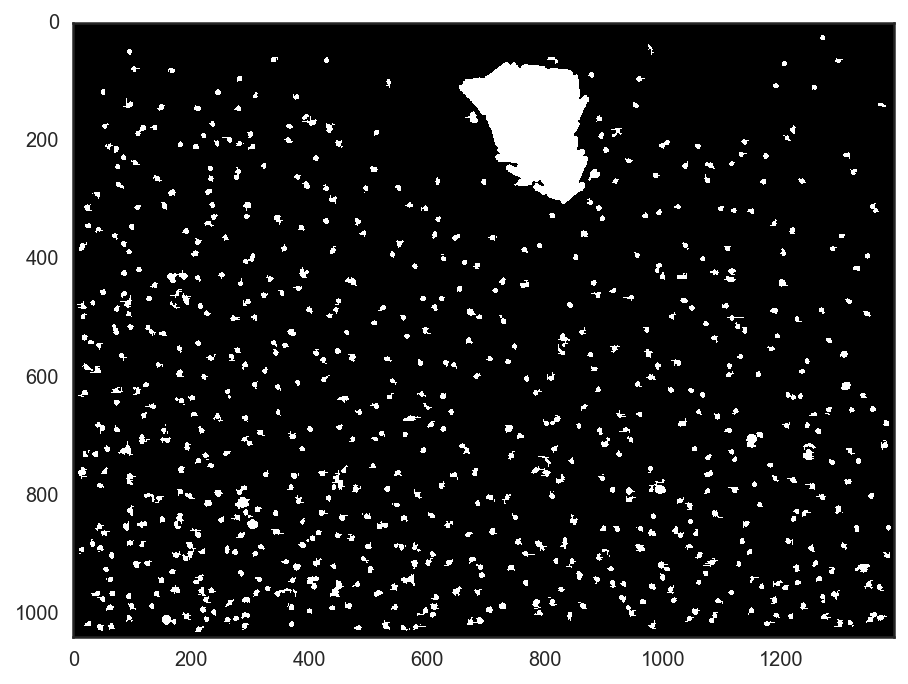

In [314]:
#Do a log segmentation of our image. 
selem = skimage.morphology.square(3)
im_log = log_segmentation(im, selem)
with sns.axes_style('white'): 
    plt.imshow(im_log, cmap=plt.cm.gray)

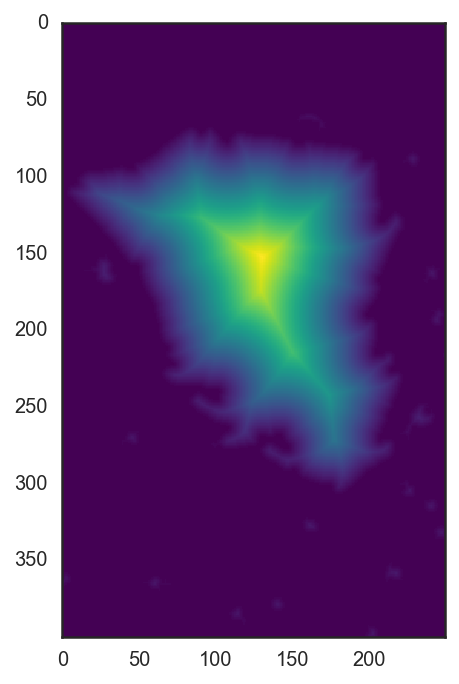

In [318]:
#compute the distances. 
distances = scipy.ndimage.distance_transform_edt(im_log)

#dist_seg = skimage.morphology.watershed(im_sobel, markers, mask=im_log)
with sns.axes_style('white'):
    plt.imshow(distances[0:400, 650:900], cmap = plt.cm.viridis)

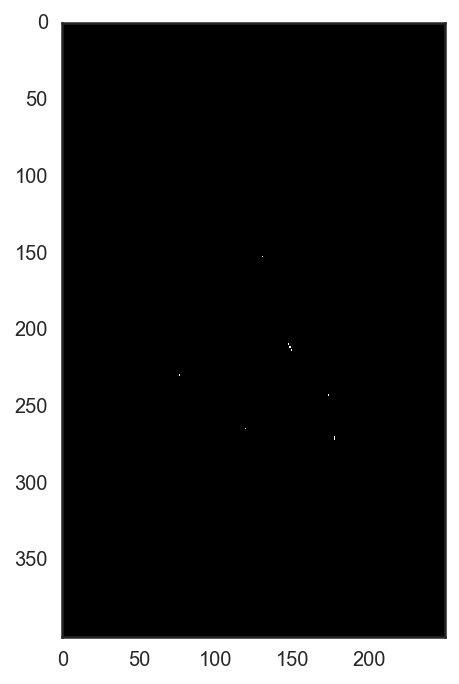

In [319]:
#Find the local maxima. 
local_maxi = skimage.feature.peak_local_max(distances, indices=False, footprint=selem,
                            labels=im_log)
with sns.axes_style('white'):
    plt.imshow(local_maxi[0:400, 650:900], cmap=plt.cm.gray)

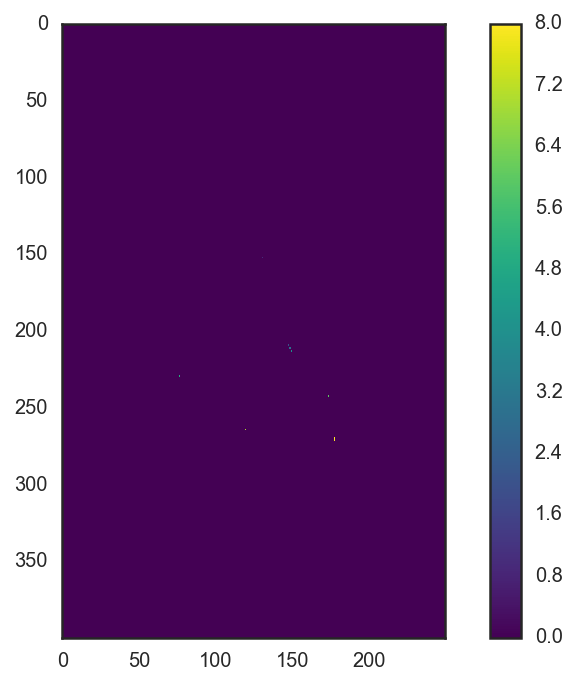

In [320]:
#Label the markers. 
markers = scipy.ndimage.label(local_maxi)[0]
with sns.axes_style('white'):
    plt.imshow(markers[0:400, 650:900], cmap=plt.cm.viridis)
    plt.colorbar()

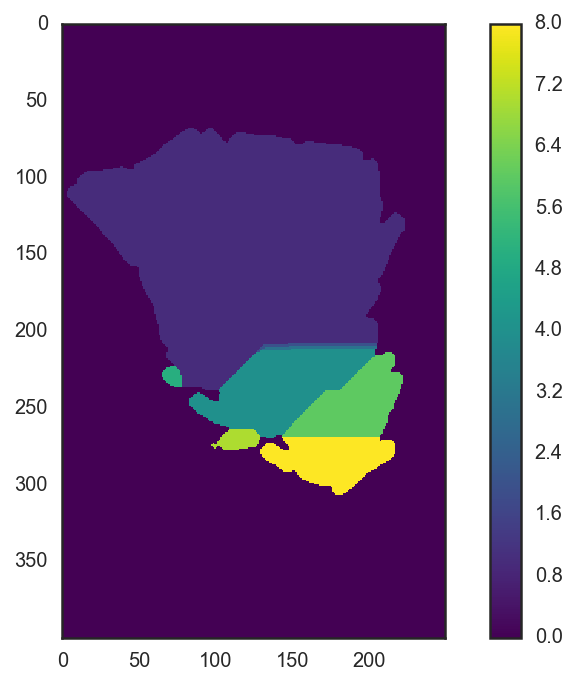

In [321]:
final_seg = skimage.morphology.watershed(-distances, markers=markers, mask=im_log)
with sns.axes_style('white'):
    plt.imshow(final_seg[0:400,650:900], cmap=plt.cm.viridis)
    plt.colorbar()

### Watershed by flooding

### Topological watershed

In [185]:
np.shape(im_log)

(400, 250)

In [ ]:
np.shape()